In [1]:
import torch
import os
import math
import time
import yaml
import pynvml
os.environ['CUDA_VISIBLE_DEVICES'] = '5'
import sys
import random
sys.path.append('/home/yang_liu/python_workspace/3DGS')
import torchvision
from os import makedirs
from torch import nn


import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scene import LargeScene, GaussianModel, GaussianModelLOD
from gaussian_renderer import render, render_v2, render_v3
from diff_gaussian_rasterization import GaussianRasterizationSettings, GaussianRasterizer
from arguments import GroupParams
from utils.general_utils import PILtoTorch
from utils.graphics_utils import getWorld2View2, getProjectionMatrix
from utils.large_utils import which_block, block_filtering
from utils.sh_utils import eval_sh
from transforms3d.euler import euler2mat, mat2euler

WARNED = False

In [31]:
class BlockedGaussian:

    gaussians : GaussianModel

    def __init__(self, gaussians, lp, range=[0, 1], scale=1.0, compute_cov3D_python=False):
        self.cell_corners = []
        self.avg_scalings = []
        self.feats = None
        self.max_sh_degree = lp.sh_degree
        self.device = gaussians.get_xyz.device
        self.compute_cov3D_python = compute_cov3D_python
        self.cell_ids = torch.zeros(gaussians.get_opacity.shape[0], dtype=torch.long, device=self.device)
        self.mask = torch.zeros(gaussians.get_opacity.shape[0], dtype=torch.bool, device=self.device)

        self.block_dim = lp.block_dim
        self.num_cell = lp.block_dim[0] * lp.block_dim[1] * lp.block_dim[2]
        self.aabb = lp.aabb
        self.scale = scale
        self.range = range

        self.cell_divider(gaussians)
        self.cell_corners = torch.stack(self.cell_corners, dim=0)

    def cell_divider(self, gaussians, n=4):
        with torch.no_grad():
            if self.compute_cov3D_python:
                geometry = gaussians.get_covariance(self.scale).to(self.device)
            else:
                geometry = torch.cat([gaussians.get_scaling,
                                      gaussians.get_rotation], dim=1)
            self.feats = torch.cat([gaussians.get_xyz,
                                    gaussians.get_opacity,  
                                    gaussians.get_features.reshape(geometry.shape[0], -1),
                                    geometry], dim=1)

            xyz = gaussians.get_xyz
            scaling = gaussians.get_scaling
            for cell_idx in range(self.num_cell):
                cell_mask = block_filtering(cell_idx, self.feats[:, :3], self.aabb, self.block_dim, self.scale)
                self.cell_ids[cell_mask] = cell_idx
                # MAD to eliminate influence of outsiders
                xyz_median = torch.median(xyz[cell_mask], dim=0)[0]
                delta_median = torch.median(torch.abs(xyz[cell_mask] - xyz_median), dim=0)[0]
                xyz_min = xyz_median - n * delta_median
                xyz_min = torch.max(xyz_min, torch.min(xyz[cell_mask], dim=0)[0])
                xyz_max = xyz_median + n * delta_median
                xyz_max = torch.min(xyz_max, torch.max(xyz[cell_mask], dim=0)[0])
                corners = torch.tensor([[xyz_min[0], xyz_min[1], xyz_min[2]],
                                       [xyz_min[0], xyz_min[1], xyz_max[2]],
                                       [xyz_min[0], xyz_max[1], xyz_min[2]],
                                       [xyz_min[0], xyz_max[1], xyz_max[2]],
                                       [xyz_max[0], xyz_min[1], xyz_min[2]],
                                       [xyz_max[0], xyz_min[1], xyz_max[2]],
                                       [xyz_max[0], xyz_max[1], xyz_min[2]],
                                       [xyz_max[0], xyz_max[1], xyz_max[2]]], device=xyz.device)
                self.cell_corners.append(corners)
                self.avg_scalings.append(torch.mean(scaling[cell_mask], dim=0))
            
            self.avg_scalings = torch.max(torch.stack(self.avg_scalings, dim=0), dim=-1).values
    
    def get_feats(self, indices):
        out = torch.tensor([], device=self.device, dtype=self.feats.dtype)
        if len(indices) > 0:
            self.mask = torch.isin(self.cell_ids, indices.to(self.device))
            out = self.feats[self.mask]
        return out

class Camera(nn.Module):
    def __init__(self, colmap_id, R, T, FoVx, FoVy, image, gt_alpha_mask,
                 image_name, uid,
                 trans=np.array([0.0, 0.0, 0.0]), scale=1.0, data_device = "cuda"
                 ):
        super(Camera, self).__init__()

        self.uid = uid
        self.colmap_id = colmap_id
        self.R = R
        self.T = T
        self.FoVx = FoVx
        self.FoVy = FoVy
        self.image_name = image_name

        try:
            self.data_device = torch.device(data_device)
        except Exception as e:
            print(e)
            print(f"[Warning] Custom device {data_device} failed, fallback to default cuda device" )
            self.data_device = torch.device("cuda")

        self.original_image = image.clamp(0.0, 1.0).to(self.data_device)
        self.image_width = self.original_image.shape[2]
        self.image_height = self.original_image.shape[1]

        if gt_alpha_mask is not None:
            self.original_image *= gt_alpha_mask.to(self.data_device)
        else:
            self.original_image *= torch.ones((1, self.image_height, self.image_width), device=self.data_device)

        self.zfar = 100.0
        self.znear = 0.01

        self.trans = trans
        self.scale = scale

        # world_view_transform = getWorld2View2(R, T, trans, scale)
        # if angle_delta is not None:
        #     R = world_view_transform[:3, :3]
        #     euler = np.array(mat2euler(R)) * 180 / np.pi
        #     euler += angle_delta
        #     R = euler2mat(*euler * np.pi / 180)
        #     world_view_transform[:3, :3] = R

        self.world_view_transform = torch.tensor(getWorld2View2(R, T, trans, scale)).transpose(0, 1).cuda()
        self.projection_matrix = getProjectionMatrix(znear=self.znear, zfar=self.zfar, fovX=self.FoVx, fovY=self.FoVy).transpose(0,1).cuda()
        self.full_proj_transform = (self.world_view_transform.unsqueeze(0).bmm(self.projection_matrix.unsqueeze(0))).squeeze(0)
        self.camera_center = self.world_view_transform.inverse()[3, :3]

def parse_cfg(cfg):
    lp = GroupParams()
    op = GroupParams()
    pp = GroupParams()

    for arg in cfg['model_params'].items():
        setattr(lp, arg[0], arg[1])
    
    for arg in cfg['optim_params'].items():
        setattr(op, arg[0], arg[1]) 

    for arg in cfg['pipeline_params'].items():
        setattr(pp, arg[0], arg[1])
    
    return lp, op, pp

def in_frustum(viewpoint_cam, cell_corners, aabb, block_dim):
    num_cell = cell_corners.shape[0]
    device = cell_corners.device

    cell_corners = torch.cat([cell_corners, torch.ones_like(cell_corners[..., [0]])], dim=-1)
    cam_center = viewpoint_cam.camera_center
    full_proj_transform = viewpoint_cam.full_proj_transform.repeat(num_cell, 1, 1)
    viewmatrix = viewpoint_cam.world_view_transform.repeat(num_cell, 1, 1)
    cell_corners_screen = cell_corners.bmm(full_proj_transform)
    cell_corners_screen = cell_corners_screen / cell_corners_screen[..., [-1]]
    cell_corners_screen = cell_corners_screen[..., :-1].reshape(-1, 3)

    cell_corners_cam = cell_corners.bmm(viewmatrix)
    mask = (cell_corners_cam[..., 2] > 0.2)

    mask_ = mask.reshape(-1)
    cell_corners_screen_ = cell_corners_screen.clone().reshape(-1, 3)
    cell_corners_screen_[~mask_] = torch.inf
    cell_corners_screen_min = cell_corners_screen_.reshape(num_cell, -1, 3).min(dim=1).values
    cell_corners_screen_min[cell_corners_screen_min==torch.inf] = 0.0

    cell_corners_screen_ = cell_corners_screen.clone().reshape(-1, 3)
    cell_corners_screen_[~mask_] = -torch.inf
    cell_corners_screen_max = cell_corners_screen_.reshape(num_cell, -1, 3).max(dim=1).values
    cell_corners_screen_max[cell_corners_screen_max==-torch.inf] = 0.0

    box_a = torch.cat([cell_corners_screen_min[:, :2], cell_corners_screen_max[:, :2]], dim=1)
    box_b = torch.tensor([[-1, -1, 1, 1]], dtype=torch.float32, device=device)
    A = box_a.size(0)
    B = box_b.size(0)
    max_xy = torch.min(box_a[:, 2:].unsqueeze(1).expand(A, B, 2),
                    box_b[:, 2:].unsqueeze(0).expand(A, B, 2))
    min_xy = torch.max(box_a[:, :2].unsqueeze(1).expand(A, B, 2),
                    box_b[:, :2].unsqueeze(0).expand(A, B, 2))
    inter = torch.clamp((max_xy - min_xy), min=0)
    mask = (inter[:, 0, 0] * inter[:, 0, 1]) > 0

    cam_center_id = which_block(cam_center[None, :], aabb, block_dim)[0]
    mask[cam_center_id] = True

    return mask

def load_gaussians(cfg, config_name, iteration=30_000, load_vq=False, deivce='cuda', source_path='../data/matrix_city/aerial/test/block_all_test'):
    
    lp, op, pp = parse_cfg(cfg)
    setattr(lp, 'config_path', cfg)
    lp.source_path = source_path
    lp.model_path = os.path.join("../output/", config_name)

    modules = __import__('scene')
    
    with torch.no_grad():
        if 'apply_voxelize' in lp.model_config['kwargs'].keys():
            lp.model_config['kwargs']['apply_voxelize'] = False
        gaussians = getattr(modules, lp.model_config['name'])(lp.sh_degree, device=deivce, **lp.model_config['kwargs'])
        scene = LargeScene(lp, gaussians, load_iteration=iteration, load_vq=load_vq, shuffle=False)
        print(f'Init {config_name} with {len(gaussians.get_opacity)} points\n')

    return gaussians, scene

def loadCamV2(args, id, cam_info, resolution_scale, pitch=None, height=None):
    orig_w, orig_h = cam_info.image.size

    if args.resolution in [1, 2, 4, 8]:
        resolution = round(orig_w/(resolution_scale * args.resolution)), round(orig_h/(resolution_scale * args.resolution))
    else:  # should be a type that converts to float
        if args.resolution == -1:
            if orig_w > 1600:
                global WARNED
                if not WARNED:
                    print("[ INFO ] Encountered quite large input images (>1.6K pixels width), rescaling to 1.6K.\n "
                        "If this is not desired, please explicitly specify '--resolution/-r' as 1")
                    WARNED = True
                global_down = orig_w / 1600
            else:
                global_down = 1
        else:
            global_down = orig_w / args.resolution

        scale = float(global_down) * float(resolution_scale)
        resolution = (int(orig_w / scale), int(orig_h / scale))

    resized_image_rgb = PILtoTorch(cam_info.image, resolution)

    gt_image = resized_image_rgb[:3, ...]
    loaded_mask = None

    if resized_image_rgb.shape[1] == 4:
        loaded_mask = resized_image_rgb[3:4, ...]

    if height is not None and pitch is not None:
        Rt = np.zeros((4, 4))
        Rt[:3, :3] = cam_info.R.transpose()
        Rt[:3, 3] = cam_info.T
        Rt[3, 3] = 1.0

        C2W = np.linalg.inv(Rt)
        euler = np.array(mat2euler(C2W[:3, :3])) * 180 / np.pi
        euler[0] = pitch
        C2W[:3, :3] = euler2mat(*euler * np.pi / 180)
        C2W[2, -1] = height
        Rt = np.linalg.inv(C2W)

        R = Rt[:3, :3].transpose()
        T = Rt[:3, 3]
    else:
        R = cam_info.R
        T = cam_info.T

    return Camera(colmap_id=cam_info.uid, R=R, T=T, 
                  FoVx=cam_info.FovX, FoVy=cam_info.FovY, 
                  image=gt_image, gt_alpha_mask=loaded_mask,
                  image_name=cam_info.image_name, uid=id, data_device=args.data_device)

def render_lod_v2(viewpoint_cam, lod_list : list, pipe, bg_color : torch.Tensor, scaling_modifier = 1.0, override_color = None):
    
    # sort cells by distance to camera
    torch.cuda.synchronize()
    start = time.time()
    in_frustum_mask = in_frustum(viewpoint_cam, lod_list[-1].cell_corners, lod_list[-1].aabb, lod_list[-1].block_dim)
    torch.cuda.synchronize()
    end = time.time()
    print(f"Time cost of In Frustum: {end - start} s")

    torch.cuda.synchronize()
    start = time.time()
    in_frustum_indices = in_frustum_mask.nonzero().squeeze(0)
    cam_center = viewpoint_cam.camera_center
    distance3D = torch.norm(lod_list[-1].cell_corners[in_frustum_mask, :, :2] - cam_center[:2], dim=2).min(dim=1).values

    focal_length = 0.5 * viewpoint_cam.image_width / math.tan(viewpoint_cam.FoVx * 0.5)
    nyquist_scalings = 2 * distance3D / focal_length
    avg_scalings = torch.stack([lod_list[i].avg_scalings for i in range(len(lod_list))], dim=0)[:, in_frustum_mask]
    
    # compare avg_scalings with nyquist_scalings to decide which lod to use
    values, lod_indices = torch.max((avg_scalings > nyquist_scalings.unsqueeze(0)).to(torch.uint8), dim=0)
    lod_indices[values==0] = len(lod_list) - 1
    torch.cuda.synchronize()
    end = time.time()
    print(f"Time cost of LoD Selection: {end - start} s")
    
    # used for BlockedGaussianV3
    out_list = []
    main_device = lod_list[-1].feats.device
    max_sh_degree = lod_list[-1].max_sh_degree
    feat_end_dim = 3 * (max_sh_degree + 1) ** 2 + 4
    
    torch.cuda.synchronize()
    start = time.time()
    for lod_idx, lod_gs in enumerate(lod_list):
        out_i = lod_gs.get_feats(in_frustum_indices[lod_indices==lod_idx])
        if out_i.shape[0] == 0:
            continue
        if out_i.device != main_device:
            out_i = torch.cat([out_i[:, :3].to(main_device), out_i[:, 3:].half().to(main_device)], dim=1)
        out_list.append(out_i)
    feats = torch.cat(out_list, dim=0)
    torch.cuda.synchronize()
    end = time.time()
    print(f"Time cost of Feature Preparation: {end - start} s")

    # feats = lod_list[1].feats
    torch.cuda.synchronize()
    start = time.time()
    means3D = feats[:, :3].float()
    screenspace_points = torch.zeros_like(means3D, dtype=means3D.dtype, requires_grad=True, device="cuda") + 0
    means2D = screenspace_points
    opacity = feats[:, 3].float()
    # If precomputed 3d covariance is provided, use it. If not, then it will be computed from
    # scaling / rotation by the rasterizer.
    scales = None
    rotations = None
    cov3D_precomp = None
    if pipe.compute_cov3D_python:
        cov3D_precomp = feats[:, feat_end_dim:].float()
    else:
        scales = feats[:, feat_end_dim:feat_end_dim+3].float()
        rotations = feats[:, (feat_end_dim+3):].float()
        
    # If precomputed colors are provided, use them. Otherwise, if it is desired to precompute colors
    # from SHs in Python, do it. If not, then SH -> RGB conversion will be done by rasterizer.
    shs = None
    colors_precomp = None
    if override_color is None:
        features = feats[:, 4:feat_end_dim].reshape(-1, (max_sh_degree+1)**2, 3).float()
        if pipe.convert_SHs_python:
            shs_view = features.transpose(1, 2).view(-1, 3, (max_sh_degree+1)**2)
            dir_pp = (means3D - viewpoint_cam.camera_center.repeat(features.shape[0], 1))
            dir_pp_normalized = dir_pp/dir_pp.norm(dim=1, keepdim=True)
            sh2rgb = eval_sh(max_sh_degree, shs_view, dir_pp_normalized)
            colors_precomp = torch.clamp_min(sh2rgb + 0.5, 0.0)
        else:
            shs = features
    else:
        colors_precomp = override_color  # check if requires masking
    
    torch.cuda.synchronize()
    end = time.time()
    print(f"Time cost of Data Preparation: {end - start} s")
    
    # Set up rasterization configuration
    torch.cuda.synchronize()
    start = time.time()
    
    tanfovx = math.tan(viewpoint_cam.FoVx * 0.5)
    tanfovy = math.tan(viewpoint_cam.FoVy * 0.5)

    raster_settings = GaussianRasterizationSettings(
        image_height=int(viewpoint_cam.image_height),
        image_width=int(viewpoint_cam.image_width),
        tanfovx=tanfovx,
        tanfovy=tanfovy,
        bg=bg_color,
        scale_modifier=scaling_modifier,
        viewmatrix=viewpoint_cam.world_view_transform,
        projmatrix=viewpoint_cam.full_proj_transform,
        sh_degree=max_sh_degree,
        campos=viewpoint_cam.camera_center, 
        prefiltered=False,
        debug=pipe.debug
    )

    rasterizer = GaussianRasterizer(raster_settings=raster_settings)

    rendered_image, radii = rasterizer(
        means3D = means3D,
        means2D = means2D,
        shs = shs,
        colors_precomp = colors_precomp,
        opacities = opacity,
        scales = scales,
        rotations = rotations,
        cov3D_precomp = cov3D_precomp)
    
    torch.cuda.synchronize()
    end = time.time()
    print(f"Time cost of Rendering: {end - start} s")

    # Those Gaussians that were frustum culled or had a radius of 0 were not visible.
    # They will be excluded from value updates used in the splitting criteria.
    return {"render": rendered_image,
            "viewspace_points": screenspace_points,
            "visibility_filter" : radii > 0,
            "radii": radii}

def render_lod(viewpoint_cam, gs_xyz, gs_feats, gs_ids, block_scalings, cell_corners, aabb, block_dim, max_sh_degree, pipe, bg_color : torch.Tensor, scaling_modifier = 1.0, override_color = None):
    
    # sort cells by distance to camera
    torch.cuda.synchronize()
    start = time.time()
    in_frustum_mask = in_frustum(viewpoint_cam, cell_corners, aabb, block_dim)
    torch.cuda.synchronize()
    end = time.time()
    print(f"Time cost of In Frustum: {end - start} s")

    torch.cuda.synchronize()
    start = time.time()
    in_frustum_indices = in_frustum_mask.nonzero().squeeze(0)
    cam_center = viewpoint_cam.camera_center
    distance3D = torch.norm(cell_corners[in_frustum_mask, :, :2] - cam_center[:2], dim=2).min(dim=1).values

    focal_length = 0.5 * viewpoint_cam.image_width / math.tan(viewpoint_cam.FoVx * 0.5)
    nyquist_scalings = 2 * distance3D / focal_length
    avg_scalings = block_scalings[:, in_frustum_mask]
    
    # compare avg_scalings with nyquist_scalings to decide which lod to use
    values, lod_indices = torch.max((avg_scalings > nyquist_scalings.unsqueeze(0)).to(torch.uint8), dim=0)
    lod_indices[values==0] = block_scalings.shape[0] - 1
    torch.cuda.synchronize()
    end = time.time()
    print(f"Time cost of LoD Selection: {end - start} s")

    torch.cuda.synchronize()
    start = time.time()
    in_frustum_indices = in_frustum_indices.squeeze() + lod_indices * block_dim[0] * block_dim[1] * block_dim[2]
    mask = torch.isin(gs_ids, in_frustum_indices.to(gs_feats.device))
    torch.cuda.synchronize()
    end = time.time()
    print(f"Time cost of Mask Generation: {end - start} s")
    
    # used for BlockedGaussianV3
    feat_end_dim = 3 * (max_sh_degree + 1) ** 2 + 1

    torch.cuda.synchronize()
    start = time.time()
    means3D = gs_xyz[mask].float()
    screenspace_points = torch.zeros_like(means3D, dtype=means3D.dtype, requires_grad=True, device="cuda") + 0
    means2D = screenspace_points
    opacity = gs_feats[mask, 0].float()
    # If precomputed 3d covariance is provided, use it. If not, then it will be computed from
    # scaling / rotation by the rasterizer.
    scales = None
    rotations = None
    cov3D_precomp = None
    if pipe.compute_cov3D_python:
        cov3D_precomp = gs_feats[mask, feat_end_dim:].float()
    else:
        scales = gs_feats[mask, feat_end_dim:feat_end_dim+3].float()
        rotations = gs_feats[mask, (feat_end_dim+3):].float()
        
    # If precomputed colors are provided, use them. Otherwise, if it is desired to precompute colors
    # from SHs in Python, do it. If not, then SH -> RGB conversion will be done by rasterizer.
    shs = None
    colors_precomp = None
    if override_color is None:
        features = gs_feats[mask, 1:feat_end_dim].reshape(-1, (max_sh_degree+1)**2, 3).float()
        if pipe.convert_SHs_python:
            shs_view = features.transpose(1, 2).view(-1, 3, (max_sh_degree+1)**2)
            dir_pp = (means3D - viewpoint_cam.camera_center.repeat(features.shape[0], 1))
            dir_pp_normalized = dir_pp/dir_pp.norm(dim=1, keepdim=True)
            sh2rgb = eval_sh(max_sh_degree, shs_view, dir_pp_normalized)
            colors_precomp = torch.clamp_min(sh2rgb + 0.5, 0.0)
        else:
            shs = features
    else:
        colors_precomp = override_color  # check if requires masking
    
    torch.cuda.synchronize()
    end = time.time()
    print(f"Time cost of Data Preparation: {end - start} s")

    torch.cuda.synchronize()
    start = time.time()
    
    # Set up rasterization configuration
    tanfovx = math.tan(viewpoint_cam.FoVx * 0.5)
    tanfovy = math.tan(viewpoint_cam.FoVy * 0.5)

    raster_settings = GaussianRasterizationSettings(
        image_height=int(viewpoint_cam.image_height),
        image_width=int(viewpoint_cam.image_width),
        tanfovx=tanfovx,
        tanfovy=tanfovy,
        bg=bg_color,
        scale_modifier=scaling_modifier,
        viewmatrix=viewpoint_cam.world_view_transform,
        projmatrix=viewpoint_cam.full_proj_transform,
        sh_degree=max_sh_degree,
        campos=viewpoint_cam.camera_center, 
        prefiltered=False,
        debug=pipe.debug
    )

    rasterizer = GaussianRasterizer(raster_settings=raster_settings)

    rendered_image, radii = rasterizer(
        means3D = means3D,
        means2D = means2D,
        shs = shs,
        colors_precomp = colors_precomp,
        opacities = opacity,
        scales = scales,
        rotations = rotations,
        cov3D_precomp = cov3D_precomp)
    
    torch.cuda.synchronize()
    end = time.time()
    print(f"Time cost of Rendering: {end - start} s")
    
    # Those Gaussians that were frustum culled or had a radius of 0 were not visible.
    # They will be excluded from value updates used in the splitting criteria.
    return {"render": rendered_image,
            "viewspace_points": screenspace_points,
            "visibility_filter" : radii > 0,
            "radii": radii}

## Render the whole lp with LoD

In [3]:
import time
import torchvision
from os import makedirs
from torch.profiler import profile, record_function, ProfilerActivity

In [4]:
iteration = 30_000
load_vq = True

config = '../config/block_mc_aerial_block_all_lr_c36_loss_5_lod.yaml'
config_name = os.path.splitext(os.path.basename(config))[0]
with open(config) as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)

lp, op, pp = parse_cfg(cfg)
setattr(lp, 'config_path', cfg)
lp.source_path = '../data/matrix_city/aerial/test/block_all_test'
lp.dist_threshold = [0] + lp.dist_threshold + [1e6]
scaling_modifier = 1.0
override_color = None
angle_delta = None

In [28]:
lod_gs_list = []
for i in range(len(lp.lod_configs)):
    config = os.path.join('..', lp.lod_configs[i])
    config_name = os.path.splitext(os.path.basename(config))[0]
    with open(config) as f:
        cfg = yaml.load(f, Loader=yaml.FullLoader)
    lod_gs, scene = load_gaussians(cfg, config_name, iteration, load_vq, source_path=lp.source_path)
    lod_gs = BlockedGaussian(lod_gs, lp, range=[lp.dist_threshold[i], lp.dist_threshold[i+1]], compute_cov3D_python=pp.compute_cov3D_python)
    lod_gs_list.append(lod_gs)

bg_color = [1,1,1] if lp.white_background else [0, 0, 0]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

Loading trained model at iteration 30000
Reading camera 741/741
Init block_mc_aerial_block_all_lr_c36_loss_5_50_lr64_vq with 11782801 points

Loading trained model at iteration 30000
Reading camera 741/741
Init block_mc_aerial_block_all_lr_c36_loss_5_66_lr64_vq with 8012304 points

Loading trained model at iteration 30000
Reading camera 741/741
Init block_mc_aerial_block_all_lr_c36_loss_5_75_lr64_vq with 5891401 points



In [6]:
cell_corners, aabb, block_dim, num_cell, max_sh_degree = lod_gs_list[-1].cell_corners, lod_gs_list[-1].aabb, lod_gs_list[-1].block_dim, lod_gs_list[-1].num_cell, lod_gs_list[-1].max_sh_degree
gs_xyz = torch.cat([lod_gs.feats[:, :3] for lod_gs in lod_gs_list], dim=0)
gs_feats = torch.cat([lod_gs.feats[:, 3:] for lod_gs in lod_gs_list], dim=0).half()
gs_ids = torch.cat([lod_gs.cell_ids+idx*num_cell for idx, lod_gs in enumerate(lod_gs_list)], dim=0).to(torch.uint8)
block_scalings = torch.stack([lod_gs_list[i].avg_scalings for i in range(len(lod_gs_list))], dim=0)
views = scene.getTrainCameras() + scene.getTestCameras()
# del lod_gs_list, lod_gs, scene

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image idx : 485
Time cost of In Frustum: 0.0026197433471679688 s
Time cost of LoD Selection: 0.0006325244903564453 s
Time cost of Mask Generation: 0.006338834762573242 s
Time cost of Data Preparation: 0.006146907806396484 s
Time cost of Rendering: 0.01371455192565918 s


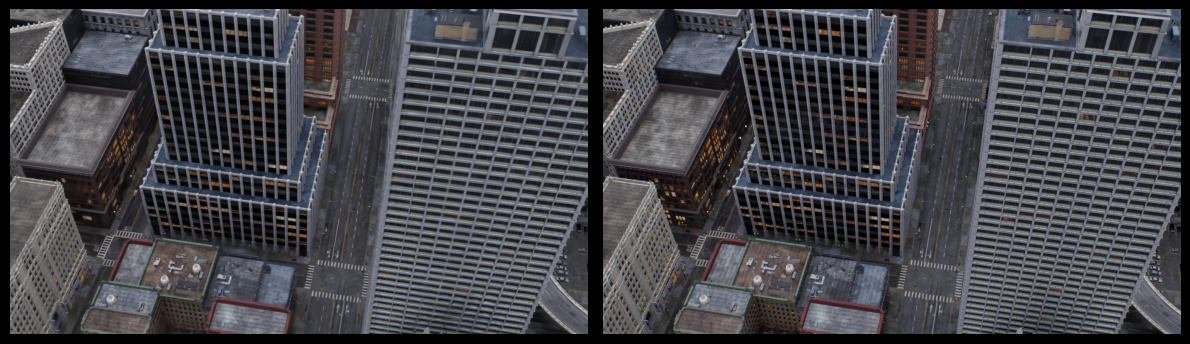

In [57]:
# idx = random.randint(0, len(views)-1)
idx = 485
print(f"Image idx : {idx}")
viewpoint_cam = loadCamV2(lp, idx, views[idx], 1.0)

with torch.no_grad():
    rendering = render_lod(viewpoint_cam, gs_xyz, gs_feats, gs_ids, block_scalings, cell_corners, aabb, block_dim, max_sh_degree, pp, background)["render"]
    # rendering = render_lod_v2(viewpoint_cam, lod_gs_list, pp, background)["render"]

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(rendering.cpu().numpy().transpose(1, 2, 0))
    plt.axis('off')
    plt.tight_layout()
    plt.subplot(1, 2, 2)
    plt.imshow(viewpoint_cam.original_image.cpu().numpy().transpose(1, 2, 0))
    plt.axis('off')
    plt.tight_layout()